# Modeler

This notebook is meant to be used interactively, to create models for breaking codes. It assumes you have already used the Librarian script to populate your filesystem and database.

## How to Use This File

Make sure you have populated your database and created credentials.py.

After configuration, the first several cells deal with reading, scaling, splitting, and shaping the data. You shouldn't need to adjust much here unless you change the data shape.

The cells related to Tuning, Building, and Training the network are meant for lots of manual experimentation. Be very conscious of data shape -- that's the topic that caused me the most trouble.

The last several cells are related to evaluating the model. Metrics reported from Tensorflow can be very misleading (presumably because I'm not using them right) so I have other checks in place. This is a good section in which to experiment with the models you create.

In [19]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import random
import pandas as pd
import sys

from credentials import CONNECTION_INFO
from constants import *
from crackers import Caesar_Cracker

import encoders
import db_connect
import helpers
import tf_helpers

# Callbacks for use with TensorFlow
from tf_helpers import modulo_output, modulo_distance_loss, modulo_distance_accuracy, modulo_rounded_accuracy, initialize_save_best

## Config
The most important variables to pay attention to:

* ENCODER: Which cipher to work on. At the moment, only encoders.ENCODER_CAESAR is doing anything interesting.
* INFER_TEXT and INFER_KEY: Whether to work on a model tries to predict decoded text, or just the key. Keys are usually a lot easier.
* CHUNK_SIZE: How many characters to process at a time. Smaller is faster and more memory-efficient, larger gives the network more information.
* EPOCHS: How many epochs to fit/train the model each time. Bump this up when you want to make a "final" model.
* ENCRYPTED_FILE_LIMIT: Maximum number of encrypted files to load up. Limit it to work faster.
* MAX_TRAIN_COUNT: Maximum number of chunks to include in training set. Limit it to work faster and reduce memory usage.
* MAX_TEST_COUNT: Maximum number of chunks to include in test set. Less impactful to memory than training count, but still relevant.
* LOAD_BEST_MODEL: Whether to load a model, as opposed to building a new one.
* BEST_PATH: Path to save tuned models, or to load models from.
* LOAD_SCALER: Whether to load scaler values from disk. If you work with a new encoder/chunk size combination, you'll need to turn this off to save new values, which can be reused later.
* TUNE_NETWORK: Whether to run the hyper-tuner, which involves a lot of fiddling with other variables.
* TRAIN_MODEL: Whether to train the network. Note you can load a network, then train it more.

### Troubleshooting
There are three recurring challenges:
* **Running Out of Memory**: If you get error messages about OS or GPU memory failures, the first thing to do is restart the kernel. If the problem continues, try reducing these values: chunk size, processing units, max train count, batch size, or (less often) max train count.
* **Kernel Crashes**: This is usually caused by memory problems. See above.
* **Data Shapes**: If you get errors from numpy or Tensorflow about data shapes or numbers of dimensions, it's probably about the relationship between input (chunks), layers in the network, output, and getting actual useful information from that output. This is just hard. Good luck!

In [20]:
ENCODER = encoders.ENCODER_CAESAR
INFER_TEXT = True
INFER_KEY = not INFER_TEXT

CHUNK_SIZE = 256
PROCESSING_UNITS = CHUNK_SIZE//4
EPOCHS = 10

ENCRYPTED_FILE_LIMIT = -1 # -1 to disable limit

BASE_TRAIN_PCT = 0.75   # If train or test count would exceed the max, they will be reduced. Note 0.75 is the default.
MAX_TRAIN_COUNT = -1 if INFER_KEY else 100000   # -1 to disable; some setups start running out of memory around 100K
MAX_TEST_COUNT =  MAX_TRAIN_COUNT               # -1 to disable

LOAD_BEST_MODEL = False # If True, model will be loaded from the path below. If False, a new model will be created from scratch.
SAVE_BEST_MODEL = True # During training, whether to keep saving the best-so-far model to disk, at the path below.
BEST_PATH = os.path.join(TEMP_MODEL_DIR, "best.keras")

LOAD_SCALER = True # If true, load from disk. If False, calculate and save to disk.
SCALER_PATH = helpers.get_recommended_scaler_path(ENCODER, CHUNK_SIZE)

# Whether to run the tuner or the hard-coded network build code
TUNE_NETWORK = False
TUNE_QUICKLY = False # Set True to sanity check the model builder
BUILD_NETWORK = not (TUNE_NETWORK or LOAD_BEST_MODEL)
TRAIN_MODEL = BUILD_NETWORK

if INFER_TEXT:
    MAIN_ACCURACY_METRIC = "mae"
    LOSS_METRIC = "mean_squared_error"
    OUTPUT_SIZE = CHUNK_SIZE
    OPTIMIZER = "RMSProp"
else:
    MAIN_ACCURACY_METRIC = "mae"
    LOSS_METRIC = "mae"
    OPTIMIZER = "RMSProp"    

    if ENCODER == encoders.ENCODER_CAESAR:
        OUTPUT_SIZE = 1
    elif ENCODER == encoders.ENCODER_SUBST:
        OUTPUT_SIZE = len(encoders.CHARSET)
    else:
        raise Exception(f"Unsupported encoder {ENCODER}")

SPLIT_SEED = 42

TUNER_DIRECTORY = "tuner_projects"
TUNER_PROJECT_NAME = "KT"

# Default is batch size is 32.
# Going higher speeds things up a LOT, but causes memory problems.
# This formula has been working OK, but still requires manual fiddling at times.
BATCH_SIZE = int(max(32, round(256 * (512/CHUNK_SIZE))))
model_checkpoint_callback = None

# Whether to run some (potentially slow) debug checks:
EXTRA_CHECKS = False

CHUNK_SIZE, PROCESSING_UNITS, BATCH_SIZE, OUTPUT_SIZE

(256, 64, 512, 256)

# Data Retrieval and Structuring

In [21]:
db = db_connect.DB(CONNECTION_INFO)

with db.get_session() as session:
    # Get database IDs for encoders and key types
    (encoder_ids, key_type_id) = db.get_id_maps(session)

    # Map source ID to plaintext file (1) details, and source ID to corresponding ciphertext files (1+) details
    (sid_to_p, sid_to_c) = db.get_source_maps(session, ENCRYPTED_FILE_LIMIT, encoder_ids[ENCODER], test_only=False)

    # Get the features (X, the cipher texts as offsets) and targets (y, either the plain texts as offsets OR the key).
    (X, y_keys, y_texts) = db.get_features_and_targets(
            session, sid_to_p, sid_to_c, ENCODER, CHUNK_SIZE, 
            want_keys=INFER_KEY or EXTRA_CHECKS, 
            want_texts=INFER_TEXT or EXTRA_CHECKS)

X = np.array(X)
if INFER_KEY:
    y = np.array(y_keys)
if INFER_TEXT:
    y = np.array(y_texts)
        
len(sid_to_p), len(sid_to_c), X.shape, y.shape, sys.getsizeof(X), sys.getsizeof(y)

(50, 50, (535650, 256), (535650, 256), 1097011328, 1097011328)

In [22]:
# For debugging and extra checks, build up a collection of all known texts

all_plaintexts = ""
all_ciphertexts = ""
if EXTRA_CHECKS:
    # Get ALL the texts in one big string, for debugging
    for sid in sid_to_p:
        all_plaintexts += helpers.read_text_file(sid_to_p[sid].path)
        for c in sid_to_c[sid]:
            all_ciphertexts += helpers.read_text_file(c.path)
    
    # Make sure specified text occurs somewhere in the texts.
    # These raise exceptions if not found.
    def check_in_plaintext(to_check: str):
        if to_check not in all_plaintexts:
            raise Exception(f"Plaintext not found: {to_check}")
    
    def check_in_ciphertext(to_check: str):
        if to_check not in all_ciphertexts:
            raise Exception(f"Ciphertext not found: {to_check}")
    

    checks = round( len(X) * 0.01)
    print(f"Checking {checks} strings")
    for _ in range(checks):
        i = random.randint(0, len(X)-1)
        check_in_plaintext(encoders.offsets_to_string(y_texts[i].astype(int)))
        check_in_ciphertext(encoders.offsets_to_string(X[i].astype(int)))

len(all_plaintexts), len(all_ciphertexts)

(0, 0)

In [23]:
# Split the preprocessed data into a training and testing dataset
# Note we have excluded "test_only" files above, they will be used for later validation.

train_count = int(round(len(y) * BASE_TRAIN_PCT))
if train_count > MAX_TRAIN_COUNT and MAX_TRAIN_COUNT > -1:
    print(f"Train count would be {train_count}")
    train_count = int(MAX_TRAIN_COUNT)
print(f"Train count is {train_count}")

test_count = len(y) - train_count
if test_count > MAX_TEST_COUNT and MAX_TEST_COUNT > -1:
    print(f"Test count would be {test_count}")
    test_count = int(MAX_TEST_COUNT)
print(f"Test count is {test_count}")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_count, test_size=test_count, random_state=SPLIT_SEED)

if EXTRA_CHECKS:
    checks = max(10, round( min(len(X_train), len(X_test)) * 0.01))
    print(f"Checking {checks} strings")
    for _ in range(checks):
        i = random.randint(0, len(X_train)-1)
        check_in_ciphertext(encoders.offsets_to_string(X_train[i].astype(int)))

        i = random.randint(0, len(X_test)-1)
        check_in_ciphertext(encoders.offsets_to_string(X_test[i].astype(int)))

# The pre-split data sets are no longer needed, and take up a lot of memory, so get rid of them
if not EXTRA_CHECKS:
    del X
    del y
    del y_keys
    del y_texts

Train count would be 401738
Train count is 100000
Test count would be 435650
Test count is 100000


In [24]:
# Create a StandardScaler instances

if LOAD_SCALER:
    print(f"Loading scaler from {SCALER_PATH}")
    X_scaler = helpers.load_scaler_from_file(SCALER_PATH)
else:
    # Fit the StandardScaler
    scaler = StandardScaler()
    print("Fitting scaler")
    X_scaler = scaler.fit(X_train)

    print(f"Saving scaler to {SCALER_PATH}")
    helpers.save_scaler_to_file(X_scaler, SCALER_PATH)
    
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)   
    
to_show = min(16, CHUNK_SIZE)
X_train_scaled.shape, X_test_scaled.shape, X_train_scaled[0][0:to_show], X_test_scaled[0][0:to_show]

Loading scaler from temp_models/scaler_Caesar_Cipher_000256.json


((100000, 256),
 (100000, 256),
 array([-1.8166039 , -1.41643136, -1.12956415, -1.6435932 , -1.70068077,
         1.5682185 , -0.60780222, -1.41690122, -0.78486035, -1.47280157,
         1.57009276, -0.78376302, -1.46963708, -1.64677028,  1.6262305 ,
        -1.70272721]),
 array([-0.55514241, -0.95714604, -1.18698783, -1.29906363, -1.18433153,
        -1.52807995, -0.60780222, -1.12984069, -1.53077882, -1.07113234,
        -0.60955782, -0.78376302, -1.23998657, -1.53189791, -0.78137369,
        -0.03791958]))

In [25]:
# Reshape the data as required for the model

print(f"Original shapes: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

X_train = tf_helpers.reshape_input_for_RNN(X_train, CHUNK_SIZE)
X_train_scaled = tf_helpers.reshape_input_for_RNN(X_train_scaled, CHUNK_SIZE)
X_test = tf_helpers.reshape_input_for_RNN(X_test, CHUNK_SIZE)
X_test_scaled = tf_helpers.reshape_input_for_RNN(X_test_scaled, CHUNK_SIZE)
y_train = tf_helpers.reshape_output_for_RNN(y_train, OUTPUT_SIZE)
y_test = tf_helpers.reshape_output_for_RNN(y_test, OUTPUT_SIZE)

print(f"Final    shapes: {X_train.shape}, {X_train_scaled.shape}, {X_test.shape}, {X_test_scaled.shape}, {y_train.shape}, {y_test.shape}")

Original shapes: (100000, 256), (100000, 256), (100000, 256), (100000, 256)
Final    shapes: (100000, 256, 1), (100000, 256, 1), (100000, 256, 1), (100000, 256, 1), (100000, 256, 1), (100000, 256, 1)


# Hyperband Tuning

In [26]:
import model_tuner

MAX_EPOCHS_PER_MODEL = 20 # Meant to get a decent idea of parameter, not create a final model. Behaves oddly below 3.
HYPERBAND_ITERATIONS = 1  # "Number of times to iterate over the full Hyperband algorithm"
EXECUTIONS_PER_TRIAL = 1  # Training from scratch
SEARCH_FIT_EPOCHS = 20    # Epochs for each attempt to do a fit, I think. Not sure how this relates to MAX_EPOCHS_PER_MODEL.
OVERWRITE = True          # I'm hoping to be able to interrupt a run and resume it later

input_shape = (None, 1, CHUNK_SIZE)
mr_t = model_tuner.ModelTuner(input_shape, OUTPUT_SIZE, CHUNK_SIZE, BATCH_SIZE)

# All-encompassing optimization parameter choices. Do not try to use all of them at once...
mr_t.CHOICES_PROCESSING_UNITS = [1, CHUNK_SIZE // 16, CHUNK_SIZE // 4, CHUNK_SIZE, CHUNK_SIZE * 2]
mr_t.CHOICES_ACTIVATIONS = ["elu", "gelu", "hard_sigmoid", "hard_silu", "hard_swish", "leaky_relu", "linear", "log_softmax", "mish",
        "relu", "relu6", "selu", "sigmoid", "silu", "softmax", "softplus", "softsign", "swish", "tanh"]
mr_t.CHOICES_FANCY_TOPO = ["GRU", "RNN", "LSTM", "GRU-RNN", "GRU-LSTM", "GRU-RNN-LSTM"] # Prefer LSTM, GRU-LSTM might be slightly more accurate, but it's so slooooow
mr_t.CHOICES_USE_OUTPUT_LIMITER = [True, False] # Prefers False, but barely
mr_t.CHOICES_OPTIMIZER = ["adamax", "sgd", "RMSProp", "adam", "Ftrl", "Lion", "Lamb"] # Prefers RMSProp

# Narrow down the choices as needed.
mr_t.CHOICES_PROCESSING_UNITS = [PROCESSING_UNITS]
mr_t.CHOICES_FANCY_TOPO = ["LSTM"]
mr_t.CHOICES_OPTIMIZER = ["RMSProp"]
mr_t.CHOICES_USE_OUTPUT_LIMITER = [False]
mr_t.PICK_FANCY_TOPO_ACTIVATIONS = False

if TUNE_QUICKLY:
    MAX_EPOCHS_PER_MODEL = 3
    HYPERBAND_ITERATIONS = 1
    EXECUTIONS_PER_TRIAL = 1
    SEARCH_FIT_EPOCHS = 4

# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    return mr_t.CreateModel(hp)

# Run the kerastuner search for best hyperparameters
if TUNE_NETWORK:
    if USE_CUSTOM_METRICS:
        objective = kt.Objective("val_modulo_distance_accuracy", direction="max")
    else:
        objective = kt.Objective(f"val_{MAIN_ACCURACY_METRIC}", direction="max")

    tuner = kt.Hyperband(
        create_model,
        objective=objective,
        max_epochs=MAX_EPOCHS_PER_MODEL,
        hyperband_iterations=HYPERBAND_ITERATIONS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        overwrite=OVERWRITE,
        directory=TUNER_DIRECTORY,
        project_name=TUNER_PROJECT_NAME)
    tuner.search(X_train_scaled, y_train, epochs=SEARCH_FIT_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_scaled, y_test))
    
    best_hyper = tuner.get_best_hyperparameters(1)[0]
    print(f"Best Hyper Values: {best_hyper.values}")
    
    nn = tuner.get_best_models(1)[0]
    eval_results = nn.evaluate(X_test_scaled, y_test, verbose=2, batch_size=BATCH_SIZE )
    print(f"Best Model Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")

    nn.save("./saved_models/tuned.keras")

# Model Creation

In [27]:
if BUILD_NETWORK:
    print("Building new model")
    nn = tf.keras.models.Sequential()

    input_shape = (None, 1, CHUNK_SIZE)    
    nn.add(tf.keras.Input(shape=input_shape[1:], name="Input_Layer"))

    activation_A = "tanh"
    recurrent_activation_A = "sigmoid"
    nn.add(tf.keras.layers.LSTM(
        PROCESSING_UNITS, return_sequences=True, activation=activation_A, recurrent_activation=recurrent_activation_A,
        name=f"A_LSTM_{activation_A}_{recurrent_activation_A}"))
    
    nn.add(tf.keras.layers.Dense(units = OUTPUT_SIZE, activation=modulo_output, name='Modulo_Layer'))

    # Check the structure of the model
    print(f"Input shape: {nn.input_shape}, Output shape: {nn.output_shape}")
    print(nn.summary())

Building new model
Input shape: (None, 1, 256), Output shape: (None, 1, 256)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A_LSTM_tanh_sigmoid (LSTM)      │ (None, 1, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Modulo_Layer (Dense)            │ (None, 1, 256)         │        16,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,816 (386.00 KB)

 Trainable params: 98,816 (386.00 KB)

 Non-trainable params: 0 (0.00 B)

None


# Model Fitting / Training

In [37]:
# The "load train loop" is a manual loop. With this on, this cell can be executed repeatedly to
# load the best scoring model, train, save the best scoring model... The idea is to keep improving,
# backtracking if scores stagnate or start to worsen.
#
# This is still pretty fiddly, requiring more manual prep if you're working with a brand new model.
LOAD_TRAIN_LOOP = True

# Set up a callback to save the model as it improves during training.
# Once it has been set up, doing this again effectively "resets" the best score,
# so be conscious of how you use it. Don't want to reset when iteratively training.
if (model_checkpoint_callback is None) or (not LOAD_TRAIN_LOOP):
    model_checkpoint_callback = initialize_save_best(BEST_PATH)

# Load model from disk
if LOAD_BEST_MODEL or LOAD_TRAIN_LOOP:
    if os.path.exists(BEST_PATH):
        print(f"Loading model from {BEST_PATH}")
        nn = tf.keras.models.load_model(BEST_PATH,
            custom_objects={
                'modulo_distance_loss': modulo_distance_loss,
                'modulo_distance_accuracy': modulo_distance_accuracy,
                'modulo_rounded_accuracy': modulo_rounded_accuracy,
                'modulo_output': modulo_output
        })
        
# Train the model
if TRAIN_MODEL or LOAD_TRAIN_LOOP:
    # Decide what metrics to use
    if USE_CUSTOM_METRICS:
        loss = modulo_distance_loss
        metrics = [modulo_distance_accuracy, modulo_rounded_accuracy]
    else:
        loss = LOSS_METRIC
        metrics = [MAIN_ACCURACY_METRIC]

    print(nn.summary())
    print(f"Training model")
    
    if SAVE_BEST_MODEL:
        callbacks = [model_checkpoint_callback]
    else:
        callbacks = None
    
    # Compile the Sequential model together and customize metrics
    nn.compile(loss=loss, optimizer=OPTIMIZER, metrics=metrics)
    
    # Fit the model to the training data
    fit_model = nn.fit(X_train_scaled, y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=BATCH_SIZE)

print(nn.summary())
print(f"Input shape: {nn.input_shape}, Output shape: {nn.output_shape}")

Loading model from temp_models/best.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A_LSTM_tanh_sigmoid (LSTM)      │ (None, 1, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Modulo_Layer (Dense)            │ (None, 1, 256)         │        16,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,634 (772.01 KB)

 Trainable params: 98,816 (386.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 98,818 (386.01 KB)

None
Training model
Epoch 1/10
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.4402 - modulo_distance_accuracy: 0.9535 - modulo_rounded_accuracy: 0.3858
Epoch 1: modulo_distance_accuracy improved from 0.95369 to 0.95441, saving model to temp_models/best.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 1.4399 - modulo_distance_accuracy: 0.9536 - modulo_rounded_accuracy: 0.3859
Epoch 2/10
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.3895 - modulo_distance_accuracy: 0.9552 - modulo_rounded_accuracy: 0.4041
Epoch 2: modulo_distance_accuracy improved from 0.95441 to 0.95541, saving model to temp_models/best.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 1.3894 - modulo_distance_accuracy: 0.9552 - modulo_rounded_accuracy: 0.4041
Epoch 3/10
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.3515 - modulo_distance_accuracy: 0.9564 - modulo_rounded_accuracy: 0.4152
Epoch 3: modulo_distance_accuracy improved from 0.95541 to 0.95633, saving model to temp_models/best.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A_LSTM_tanh_sigmoid (LSTM)      │ (None, 1, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Modulo_Layer (Dense)            │ (None, 1, 256)         │        16,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,634 (772.01 KB)

 Trainable params: 98,816 (386.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 98,818 (386.01 KB)

None
Input shape: (None, 1, 256), Output shape: (None, 1, 256)


# Model Evaluation
Cells below give a few different ways to judge the usefulness of the model.

In [29]:
# Select some data for testing below...

# Predicting the whole test set can take a lot of memory, so this can be used to limit it:
TEST_SET_SIZE = X_test_scaled.shape[0]
MAX_TEST_SUBSET = -1
TEST_SUBSET_SIZE = min(TEST_SET_SIZE, MAX_TEST_SUBSET) if MAX_TEST_SUBSET > 0 else TEST_SET_SIZE
X_test_scaled_subset = X_test_scaled[0:TEST_SUBSET_SIZE, :, :]
y_test_subset = y_test[0:TEST_SUBSET_SIZE, :, :]

# Sometimes for troubleshooting I want to use the training set, which should produce more accurate predictions:
TRAIN_SET_SIZE = X_train_scaled.shape[0]
MAX_TRAIN_SUBSET = MAX_TEST_SUBSET
TRAIN_SUBSET_SIZE = min(TRAIN_SET_SIZE, MAX_TRAIN_SUBSET) if MAX_TRAIN_SUBSET > 0 else TRAIN_SET_SIZE
X_train_scaled_subset = X_train_scaled[0:TRAIN_SUBSET_SIZE, :, :]
y_train_subset = y_train[0:TRAIN_SUBSET_SIZE, :, :]

use_training_data = False
if use_training_data:
    print("Using training data as input; results are not valid for accuracy but may be informative about function")
    input = X_train_scaled_subset
    expected = y_train_subset
else:
    print("Using test data as input")
    input = X_test_scaled_subset
    expected = y_test_subset

input.shape, expected.shape

Using test data as input


((100000, 256, 1), (100000, 256, 1))

### Tensorflow Evaluate()
Calling model.evaluate() is the easiest and most standard way to measure the model's effectiveness, but I'm not sure the numbers are reliable. Between the use of custom metric functions and my uncertainty about data shape, these results could be misleading.

Other cells below look closer at results.

In [30]:
print("Evaluating test set with model.evaluate() ...")
eval_results = nn.evaluate(X_test_scaled_subset, y_test_subset, batch_size=BATCH_SIZE)
print(f"Test Set        : Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")

print("Evaluating training set with model.evaluate() --  should tend to be somewhat better...")
eval_results = nn.evaluate(X_train_scaled_subset, y_train_subset, batch_size=BATCH_SIZE)
print(f"Training Set    : Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")    

Evaluating test set with model.evaluate() ...
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 7.3047 - modulo_distance_accuracy: 0.7644 - modulo_rounded_accuracy: 0.0474
Test Set        : Loss: 7.303733825683594, Accuracy: [0.7643992304801941, 0.04736940562725067]
Evaluating training set with model.evaluate() --  should tend to be somewhat better...
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 7.3050 - modulo_distance_accuracy: 0.7644 - modulo_rounded_accuracy: 0.0474
Training Set    : Loss: 7.304385185241699, Accuracy: [0.7643753290176392, 0.04737791419029236]


             Loss  Accuracy (Distance)  Accuracy (Rounded)
count  256.000000           256.000000          256.000000
mean     7.372154             0.762189            0.045158
std      0.002080             0.000067            0.000942
min      7.367521             0.761961            0.043785
25%      7.370371             0.762134            0.044327
50%      7.372262             0.762185            0.044801
75%      7.373859             0.762246            0.046106
max      7.379214             0.762338            0.046861


<Axes: xlabel='Offset'>

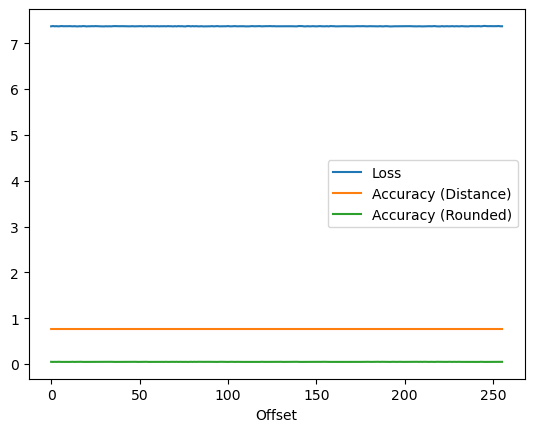

In [31]:
# This code was used to determine where to find the single best result from
# the prediction. It will be moved to the analsis notebook...

col_offset = []
col_loss = []
col_acc_dist = []
col_acc_round = []

# Looping through individual inputs is horribly slow, but I specifically wanted this
# so I could relate behaviors to what I could actually see.
HOW_MANY = 10
for _ in range(HOW_MANY):
    which_input = random.randint(0, input.shape[0]-1)
    this_input = input[which_input:which_input+1, :, :]
    this_expected = expected[which_input:which_input+1, :, :]

    raw_predicted = nn.predict(this_input, batch_size=BATCH_SIZE, verbose=0)
    this_predicted = raw_predicted.astype(np.float64)

    offsets = range(0, CHUNK_SIZE)
    for offset in offsets:
        # I don't know why these are different:
        if INFER_TEXT:
            offset_predicted = this_predicted[:, :, offset]
        if INFER_KEY:
            offset_predicted = this_predicted[:, offset, :]
            
        loss = modulo_distance_loss(this_expected, offset_predicted)
        accuracy_distance = modulo_distance_accuracy(this_expected, offset_predicted)
        accuracy_rounded = modulo_rounded_accuracy(this_expected, offset_predicted)

        col_offset.append(offset)
        col_loss.append(loss.numpy())
        col_acc_dist.append(accuracy_distance.numpy())
        col_acc_round.append(accuracy_rounded.numpy())

metrics_df = pd.DataFrame({
    "Offset": col_offset,
    "Loss": col_loss,
    "Accuracy (Distance)": col_acc_dist,
    "Accuracy (Rounded)": col_acc_round 
}).set_index("Offset")

metrics_df = metrics_df.groupby(['Offset']).mean()
print(metrics_df.describe())
metrics_df.plot()

### Model Usefulness Spot-Check
This cell measures accuracy in a more intuitive, but less mathematically rigorous, way. It's also much, much slower, and currently only works with the Caesar cipher.

This is mean to supplement the metrics that come out of Tensorflow.

In [32]:
FILES_TO_CHECK = 10
if INFER_TEXT:    
    CHUNKS_TO_CHECK = 1
else:
    CHUNKS_TO_CHECK = 200

good=0
bad=0
for _ in range(FILES_TO_CHECK):
    sid = random.choice(list(sid_to_c.keys()))
    cipher_file_db = random.choice(sid_to_c[sid])
    ciphertext_path = cipher_file_db.path
    ciphertext = helpers.read_text_file(ciphertext_path)
    length = min(CHUNK_SIZE * CHUNKS_TO_CHECK, len(ciphertext))
    ciphertext = ciphertext[0:length]
    
    if INFER_KEY:
        cracker = Caesar_Cracker(X_scaler, nn, None)
    
        with db.get_session() as session:
            correct_key = int(db.get_key_by_id(session, cipher_file_db.key_id).value)
        
        inferred_key = cracker.infer_key_with_model(ciphertext)

        if correct_key == inferred_key:
            good += 1
        else:
            bad += 1
    if INFER_TEXT:
        cracker = Caesar_Cracker(X_scaler, None, nn)
    
        with db.get_session() as session:
            correct_key = int(db.get_key_by_id(session, cipher_file_db.key_id).value)
            
        inferred_text = cracker.infer_text_with_model(ciphertext)
        print("Ciphertext:\n", ciphertext[0:128])
        print("Decoded   :\n", inferred_text[0:128])
        print()

if good + bad > 0:
    good_percent = float(good)/float(good+bad)
    luck_percent = float(1)/float(len(encoders.CHARSET))
    
    print(f"Good results: {good} / {bad} ({good_percent:.2%})")
    print(f"Chance of randomly getting the right key: {luck_percent:.2%}")

Ciphertext:
 OO9WTNPS-T3907T8N4UN74ST7XRZN7P3S42OOQ!N94QXP8N82411T99OOR439T398OON9WTNP09W478N57TUPRTONP5414V0TONRWP59T7NXIONRWP59T7NXXIONRWP5
Decoded   :
 CFHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHIHIHHHHHHIHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

Ciphertext:
 BBVTCPUETKDGT"UAPQVG,AVCDNGAQHAEQPVGPVUACFFGFAD1AVTCPUETKDGTACPFARNCEGFBKPVQAVJGARWDNKEAFQOCKP<ADQNFHCEGAVGZVAKUAKPFKECVGFACUA!G
Decoded   :
 CEGHHHHHHHHHHIHHHHHHIGHHHHHHHHHHHHHHHHHHHHHHHHHHGHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHIGHHHHHHHHHHHHHHHHHHHHHHHHHHHHHGIH

Ciphertext:
 PP08Q49S8YRU89O450UGO0QR2UO5VOS540U409OQTTUTOR#O08Q49S8YRU8OQ4TO62QSUTPY405O0XUO6-R2YSOT53QY4JOR52TVQSUO0U!0OY9OY4TYSQ0UTOR#O"U7
Decoded   :
 CFHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHIHIHHHHHHHHHHHHHHHHHHHHHHHHHHHIHHHHHHHHHHHHHHHHHHHHHHHHHHHHHIHHHHHHHHHHHHHHHHIHIHH

Ciphertext:
 77[;+-"0=-69<6%=;+=)6#=**$)!(8)68)-6:#=6+)*$)=6-$':;$9":=-7[;++`;=8-$)!6:=8(68:6#::[X22...1[!-[1)=:6Q:#$'6`$*=6.8'7[;+-"0=-6`;+(
Dec